<a href="https://colab.research.google.com/github/TAYAyuki/adversarial_example/blob/master/Adversarial_exapmle_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd #データ解析
import keras
import tensorflow as tf
import matplotlib.pyplot as plt


What we want our adversarial example to look like: 


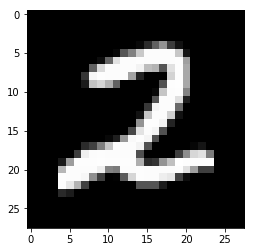



Adversarial Example: 


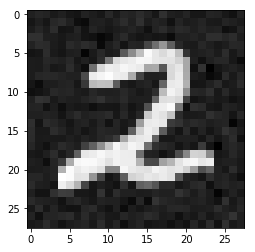

Network Prediction: 8

Network Output: 
[[0.08 0.06 0.14 0.1  0.07 0.07 0.07 0.09 0.17 0.13]]



In [42]:
def input_derivative(model, x, goal):
  #model, x : (1,784)の乱数, goal : 8のone_hot_vector
  """ Calculate derivatives wrt the intputs """
  #モデルの定義
  y_true = keras.layers.Input(shape=(10,)) #y_trueの形状を作っている
  ce = keras.losses.categorical_crossentropy(y_true, model.output) #y_true : 8のone_hot_vector, model.output : 2のone_hot_vector ? 
  grad_ce = tf.keras.backend.gradients(ce, model.inputs) #ce : 2 と 8のクロスエントロピー誤差 model.inputs : (1.784)の乱数(ノイズ) の勾配を求めている
 
  # Create a function to be able to run this computation graph
  func = keras.backend.function(model.inputs + [y_true], grad_ce) #model.inputs : (1,784)の乱数  y_true : 8のone_hoe_vector grad_ce : 出力
  #function(inputs,outputs) どちらもリスト 
  output = func([x, goal]) #[x : (1,784)の乱数(ノイズ) goal : 8のone_hot_vector] <- input
  return output #(1,784)の乱数と 2.8 のクロスエントロピー誤差 の勾配

def adversarial(model, n, steps, eta):
  """
  model: MNIST model
  n:     integer. goal label (just an int, the function transfroms it into a one-hot vector)
  steps: integer. number of steps for gradient descent
  eata:  integer. step size for gradient descent
  """
  # Set the goal output
  goal = tf.keras.utils.to_categorical(n, 10)
  # Create a random image to initialize gradient descent with
  x = np.random.normal(.5, .3, (1,784))
  # Gradient descent on the input
  for i in range(steps):
    # Calculate the derivative
    d = input_derivative(model, x, goal)
    # The Gradient update on x
    x -= eta*d[0]
    print("step:{} done...".format(i+1))
  return x

def generate(n):
  """
  n: integer
  goal label ( not hot vector)
  """
  a = adversarial(model, n, 100, 1)
  x = np.round(model.predict(a), 2)
  plt.imshow(a.reshape(28,28), cmap='gray')


def sneaky_adversarial(model, n, x_target, steps, eta, lam=0.5): 
  #引数 : model, n=8, x_test:２の画像のピクセル, steps=10(勾配降下のステップ数), eta=1, lam=0.5 
  """
  model:    model object
  n:        integer
       our toal label
  x_target: numpy vector
        our goal image for the adversarial example
  steps:    integer
        number of steps for gradient descent
  lam:      float
       lambda, our regularization parameter. Default is 0.5
  """

  # Set the goal output
  goal = tf.keras.utils.to_categorical(n, 10) #n:8をone_hot_vectorにしている
   
  # Create a random noise
  x = np.random.normal(0.5, 0.3, (1,784)) #平均0.5　標準偏差0.3の正規分布に従って(1,784)の乱数を生成
 
  # Gradient descent on the input
  for i in range(steps):
    # Calculate the derivative
    d = input_derivative(model, x, goal) #model, x:(1,784)の乱数, goal:8のone_hot_vector
    # The grads update on x, with an added penalty to the cost function
    x -= eta * (d[0] + lam * (x - x_target)) #ノイズから2の画像ピクセルを引いて,勾配をたす
  return x


def sneaky_generate(n, m): #n : 8 m : 2
  """
  n:    int 0-9, the target number to match
  m:    index of example image to use (from the test set)
  """
  # Find random instance of m in test set 
  idx = np.random.randint(0,10000)
  #y_test[idx] : [0,0,0,1,0,0,0,0,0,0]
  
  #np.where(y_test[idx] == 1) : y_test[idx] を順にみて1の時のindexを返す
  #上の例だと 3 を返す. しかしnumpy配列 (array([3]),)となっている  -> [0][0]が必要
  while np.where(y_test[idx] == 1)[0][0] != m:  #2になるものを探している
    idx += 1
  # Hardcode the parameters for the wrapper function
  a = sneaky_adversarial(model, n, x_test[idx], 10, 1) #引数 : model, n=8, x_test[idx]:２の画像のピクセル, 勾配降下のステップ数=10, eta=1 
  #a : ２に見えるけど8だと認識される画像のピクセル情報が入っている
  x = np.round(model.predict(a), 2) #小数点第３位で四捨五入する 
  #x: 認識した文字のone_hot_vector index:8 が一番値が大きいはず
  print('\nWhat we want our adversarial example to look like: ')
  plt.imshow(x_test[idx].reshape((28,28)), cmap='gray')
  plt.show()
  print('\n')
  print('Adversarial Example: ')
  plt.imshow(a.reshape(28,28), cmap='gray') 
  plt.show()
  print('Network Prediction: ' + str(np.argmax(x)) + '\n') #xの中の最大のindexを返す
  print('Network Output: \n' + str(x) + '\n')
  return a 

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
#x_train : (60000,28,28)  y_train : (60000,)
#x_test : (10000,28,28)   y_test : (10000,)
y_train = tf.keras.utils.to_categorical(y_train, 10) #正解ベクトルをone_hot_vectorにする
y_test = tf.keras.utils.to_categorical(y_test, 10) 
x_train = x_train.reshape(60000,28*28) #x を二次元配列
x_test = x_test.reshape(10000,28*28)
#x_train : (60000,784)  x_test : (10000, 784)
x_train = x_train/255. #x_train 正規化
x_test = x_test/255. #x_test 正規化

a = keras.layers.Input(shape=(28*28,))
x = keras.layers.Dense(units=512, activation='relu', input_shape=(28*28,))(a)
x = keras.layers.Dense(units=128, activation='relu')(x)
x = keras.layers.Dense(units=64, activation='relu')(x)
x = keras.layers.Dense(units=10, activation='softmax')(x)

model = keras.models.Model(inputs=a, outputs=x) 
model.compile(optimizer=keras.optimizers.Adadelta(), loss='categorical_crossentropy', metrics=['accuracy'])
#model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test))

"""
Akari
a = keras.layers.Input(shape=(28*28,))
x = keras.layers.Conv2D(20, (3, 3), padding="valid", activation=tf.nn.relu,)(a)
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
x = keras.layers.Conv2D(50, (3, 3), padding="valid", activation=tf.nn.relu,)(x)
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(225, activation=tf.nn.relu)(x)
x = keras.layers.Dense(10, activation="softmax")(x)
"""

# sneaky_generate(target label, target digit) 
# target label : 錯覚させる正解ラベル
# target digit: 画像上で表されている数字
adv_ex = sneaky_generate(8, 2)